In [2]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Fix the lastest ref feature

In [3]:
data = pd.read_pickle('./features/all_data_features_csv_17_20_new.pkl')
print(data.shape)
data.head(5)

(4897, 24)


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label,ref_latest_depth
2017_HJIY0E9ge,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,250,13,0,25,1,1,1,0,Reject,2
2017_BkdpaH9ll,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,48,14,0,10,1,1,1,2,Reject,2
2020_rkecl1rtwB,2020_rkecl1rtwB,2,40,6,918,134,3,16,2019,12,...,41,24,1,20,1,1,1,3,Accept,2
2019_HkgYmhR9KX,2019_HkgYmhR9KX,5,75,11,1761,266,4,36,2019,24,...,48,16,1,26,1,1,1,0,Accept,1
2020_ryxW804FPH,2020_ryxW804FPH,3,68,8,750,112,4,31,2019,20,...,33,10,1,17,1,1,1,2,Reject,2


In [4]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'ref_latest_depth'],
      dtype='object')

In [5]:
data["ref_latest_depth"] = data["id"].apply(lambda x: int(x.split("_")[0])) - data["ref_latest"] + 1

In [6]:
data.to_pickle('./features/all_data_features_csv_17_20_new.pkl')

In [ ]:
# If you want, shuffle the data
data = data.sample(n=len(data), random_state=42)

# Status till now

Replicate the results of the best model for comparison

In [14]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=2),
            'RandomForest':RandomForestClassifier(max_depth=3),
            'LogisticR':LogisticRegression(max_iter=1000),
            'LogisticLassoR':LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=1000),
            'SVC':SVC(kernel='rbf'),
            'SVCPoly': SVC(kernel='poly', degree=3, gamma='auto'),
            'SVCLin': SVC(kernel='linear'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

In [15]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
                         out_file=dot_data, 
                         class_names=['Accept','Reject'], # the target names.
                         feature_names=X.columns, # the feature names.
                         filled=True, # Whether to fill in the boxes with colours.
                         rounded=True, # Whether to round the corners of the boxes.
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

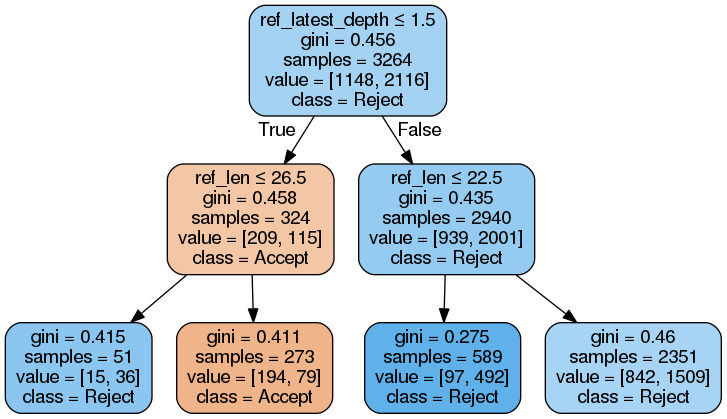

In [ ]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X #/ X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [ ]:
model_results

In [19]:
model_results

,Accuracy,CVresults
RandomForest,0.665712,"{'test_score': [0.6723821187997551, 0.66299019..."
LogisticLassoR,0.657752,"{'test_score': [0.6454378444580526, 0.66237745..."
GaussianProcessClf,0.652237,"{'test_score': [0.6454378444580526, 0.64950980..."
NeuralNet,0.66061,"{'test_score': [0.6546233925290875, 0.66421568..."
GaussNB,0.636106,"{'test_score': [0.6270667483159829, 0.63664215..."
LogisticR,0.659589,"{'test_score': [0.6503368034292712, 0.66421568..."
RidgeClf,0.658977,"{'test_score': [0.647887323943662, 0.659313725..."
DecisionTree,0.678374,"{'test_score': [0.6821800367421923, 0.67585784..."
SVC,0.648152,"{'test_score': [0.647887323943662, 0.648284313..."
KNN,0.614459,"{'test_score': [0.6099203919167177, 0.61274509..."


In [21]:
data.to_csv("features/reproducible_dataset_iclr_2017_2020.csv", encoding='utf-8', index=False)

In [ ]:
data = pd.read_csv("../features/reproducible_dataset_iclr_2017_2020.csv")

# Add new features

In [75]:
text_clarity_ldb_abl = pd.read_pickle("features/writing_clarity_ldb_abl.pkl")

In [76]:
text_clarity_ldb_abl.columns

Index(['cdate', 'content', 'ddate', 'details', 'forum', 'id', 'invitation',
       'label', 'nonreaders', 'number', 'original', 'readers', 'referent',
       'replyto', 'signatures', 'tcdate', 'tmdate', 'writers', 'title',
       'authors', 'abstract', 'keywords', 'tldr', 'ref_len', 'ref_latest',
       'ref_years', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
       'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
       'abl_table_count', 'abs_cons_cosine'],
      dtype='object')

In [77]:
new_features = ['np_count_abs', 'nsubj_count_abs', 'dobj_count_abs', 'np_count_title', 'cons_inters_abs', 
                'jc_cfp', 'ldb_table_count', 'abl_table_count', 'abs_cons_cosine']

In [78]:
print(data.shape)

(4897, 33)


In [79]:
for index, row in data.iterrows():
    for nf in new_features:
        data.loc[index, nf] = text_clarity_ldb_abl[text_clarity_ldb_abl["id"]==index][nf].get_values()[0]

In [80]:
data.columns, data.shape

(Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
        'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
        'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
        'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
        'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
        'contains_figure', 'contains_equation', 'iclr_references', 'label',
        'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
        'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
        'abl_table_count', 'abs_cons_cosine'],
       dtype='object'), (4897, 33))

In [81]:
data.head(5)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
2017_HJIY0E9ge,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,2,5.833333,1.500000,1.500000,0.0,1.800000,0.032258,0.0,0.0,0.657281
2017_BkdpaH9ll,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,2,7.166667,1.000000,2.000000,2.0,1.400000,0.085714,2.0,0.0,0.668052
2020_rkecl1rtwB,2020_rkecl1rtwB,2,40,6,918,134,3,16,2019,12,...,2,5.166667,2.333333,0.666667,1.0,0.800000,0.015152,0.0,3.0,0.672600
2019_HkgYmhR9KX,2019_HkgYmhR9KX,5,75,11,1761,266,4,36,2019,24,...,1,5.615385,1.615385,1.153846,4.0,1.500000,0.011364,0.0,0.0,0.652189
2020_ryxW804FPH,2020_ryxW804FPH,3,68,8,750,112,4,31,2019,20,...,2,4.857143,1.285714,1.857143,4.0,0.666667,0.048387,0.0,0.0,0.689445


In [82]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
2020_r1gx60NKPS,2020_r1gx60NKPS,5,55,8,355,57,7,17,2019,12,...,2,14.0,2.0,8.0,2.0,NaN,0.039216,0.0,0.0,NaN


In [91]:
data.loc["2020_r1gx60NKPS", "abs_cons_cosine"] = 0.0
data.loc["2020_r1gx60NKPS", "cons_inters_abs"] = 0.0

print(data[data["id"]=="2020_r1gx60NKPS"]["abs_cons_cosine"])

2020_r1gx60NKPS    0.0
Name: abs_cons_cosine, dtype: float64


In [92]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine


In [96]:
data.to_csv("features/FINAL_reproducible_dataset_iclr_2017_2020.csv", encoding='utf-8', index=False)

# Model

In [4]:
# Read reproducible data from file
data = pd.read_csv("features/FINAL_reproducible_dataset_iclr_2017_2020.csv")
print(data.shape)
data.head(2)

(4897, 33)


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
0,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,2,5.833333,1.5,1.5,0.0,1.8,0.032258,0.0,0.0,0.657281
1,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,2,7.166667,1.0,2.0,2.0,1.4,0.085714,2.0,0.0,0.668052


In [93]:
data.shape, data.columns

((4897, 33), Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
        'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
        'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
        'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
        'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
        'contains_figure', 'contains_equation', 'iclr_references', 'label',
        'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
        'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
        'abl_table_count', 'abs_cons_cosine'],
       dtype='object'))

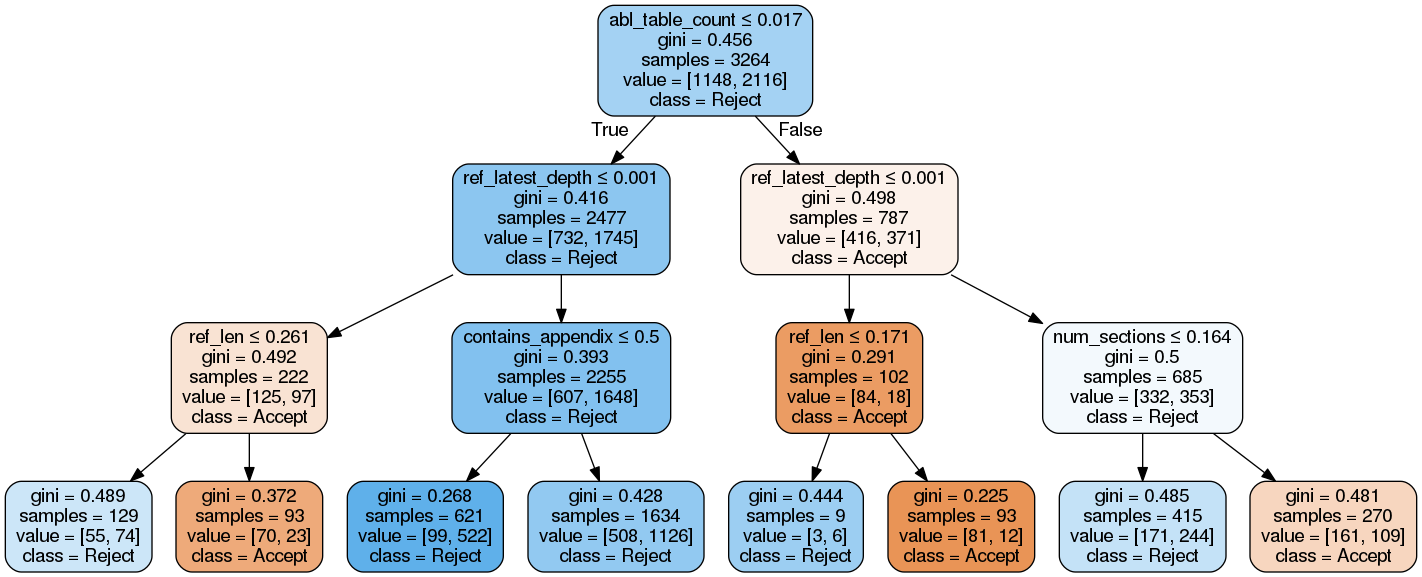

In [94]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [95]:
model_results

,Accuracy,CVresults
RandomForest,0.677352,"{'test_score': [0.683404776484997, 0.667279411..."
LogisticLassoR,0.674904,"{'test_score': [0.6723821187997551, 0.67279411..."
GaussianProcessClf,0.669389,"{'test_score': [0.6729944886711574, 0.66237745..."
NeuralNet,0.679396,"{'test_score': [0.6785058175137784, 0.68198529..."
GaussNB,0.661632,"{'test_score': [0.6491120636864667, 0.66666666..."
LogisticR,0.674903,"{'test_score': [0.6736068585425597, 0.67218137..."
RidgeClf,0.675107,"{'test_score': [0.6748315982853643, 0.67279411..."
DecisionTree,0.683478,"{'test_score': [0.6907532149418248, 0.67524509..."
SVC,0.648152,"{'test_score': [0.647887323943662, 0.648284313..."
KNN,0.610374,"{'test_score': [0.6093080220453154, 0.60784313..."


## Feature importance using Logistic Lasso

In [8]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
y = data['label']
X_normalized = X / X.max(axis=0)

clf = LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear')

results = cross_validate(clf, X_normalized, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])

print(accuracy)

0.6749035167241014


In [10]:
clf.feature_importances_

AttributeError: 'tuple' object has no attribute 'feature_importances_'